<a href="https://colab.research.google.com/github/ioloi1128/CDA/blob/main/CDA_week6_k_mean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy
!pip install xarray
!pip install matplotlib
!pip install scipy
!pip install pandas

!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy

!apt-get -V -y -qq install python-cartopy python3-cartopy
!pip uninstall shapely -y
!pip install shapely --no-binary shapely

In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

In [ ]:
from sklearn.cluster import KMeans

K-mean basic

In [ ]:
X = np.random.rand(100,2)
plt.scatter(X[:,0],X[:,1],s=50)


In [ ]:
#請KMeans分成幾類
km = KMeans(n_clusters=4)

In [ ]:
#開始訓練！
km.fit(X)

In [ ]:
#取得預測結果
km.labels_

In [ ]:
# The lowest SSE value
km.inertia_

In [ ]:
# Final locations of the centroid
km.cluster_centers_

In [ ]:
#plotting
plt.scatter(X[:,0],X[:,1], c=km.labels_,cmap='plasma')
plt.scatter(km.cluster_centers_[:,0], km.cluster_centers_[:,1], 
           marker="*", c="r", s=100, label="centroids")

In [ ]:
from collections import Counter
Counter(km.labels_)

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

In [ ]:
visualizer = KElbowVisualizer(km, k=(1,12)).fit(X)
visualizer.show()

The application of climate data

In [ ]:
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds = xr.open_dataset(url)


# select period
ds = ds.sel(time=slice('1960', '2020'))


#actually load the data
ds.load()

In [ ]:
#make anomaly
sst_clim = ds.sst.groupby('time.month').mean(dim='time')
sst_anom = ds.sst.groupby('time.month') - sst_clim


In [ ]:
#detrend
from scipy.signal import detrend
sst_anom_detrended = xr.apply_ufunc(detrend, sst_anom.fillna(0),
                                    kwargs={'axis': 0}).where(~sst_anom.isnull())

In [ ]:
sst_anom.mean(dim=['lon', 'lat']).plot(label='raw')
sst_anom_detrended.mean(dim=['lon', 'lat']).plot(label='detrended')
plt.grid()
plt.legend()

In [ ]:
ds_raw=sst_anom.mean(dim=['lon', 'lat'])
ds_detrend=sst_anom_detrended.mean(dim=['lon', 'lat'])

xtime=sst_anom['time']
nt=len(xtime)
xts=np.arange(0, nt, 1)
ds_raw

In [ ]:
import numpy as np

comX=[xts,ds_raw]
X1=np.transpose(comX)


In [ ]:
plt.scatter(X1[:,0],X1[:,1],s=50)

In [ ]:
km1 = KMeans(3)
km1.fit(X1)

The application of map

In [ ]:
#read precipitation
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/gpcp/precip.mon.mean.nc'
ds_prec = xr.open_dataset(url)
ds_prec = ds_prec.sel(time=slice('1979', '2019'))
ds_prec.load()
ds_prec

In [ ]:
ds_climo=ds_prec.groupby('time.month').mean()
ds_anoms=ds_prec.groupby('time.month')-ds_climo
ds_anoms

<xarray.Dataset>
Dimensions:   (lat: 72, lon: 144, nv: 2, time: 492)
Coordinates:
  * lat       (lat) float32 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon       (lon) float32 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * time      (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2019-12-01
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: nv
Data variables:
    lat_bnds  (time, lat, nv) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    lon_bnds  (time, lon, nv) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    precip    (time, lat, lon) float32 -0.02191 -0.03154 ... -0.2816 -0.2292

In [ ]:
#select domain
latS=-30
latN=30
lonL=100
lonR=300
ds_anoms_TP = ds_anoms.sel(lat=slice(latS, latN), lon=slice(lonL, lonR))

nt = len(ds_anoms_TP['time'])
ny = len(ds_anoms_TP['lat'])
nx = len(ds_anoms_TP['lon'])
print(nt, ny, nx)
data = ds_anoms_TP['precip'].values
ds_anoms_2d = np.reshape(data, [nt, ny*nx],order='F')
mk2 = KMeans(n_clusters=4).fit(ds_anoms_2d)

In [ ]:
def get_cluster_fraction(m, label):        
        return (m.labels_==label).sum()/(m.labels_.size*1.0)

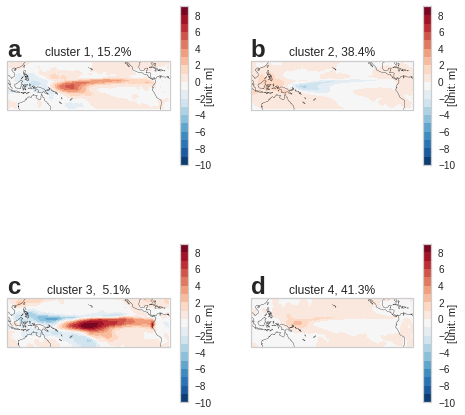

In [ ]:
x,y = np.meshgrid(ds_anoms_TP.lon, ds_anoms_TP.lat)
proj = ccrs.PlateCarree(central_longitude=180)
fig, axes = plt.subplots(2,2, figsize=(8,8), subplot_kw=dict(projection=proj))
regimes = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4']
tags = list('abcd')
for i in range(mk2.n_clusters):
    onecen = mk2.cluster_centers_[i,:].reshape(ny,nx, order='F')
    cs = axes.flat[i].contourf(x, y, onecen,
                               levels=np.arange(-10, 10, 1), 
                               transform=ccrs.PlateCarree(),
                               cmap='RdBu_r')
    
    cb=fig.colorbar(cs, ax=axes.flat[i], shrink=0.8, aspect=20) 
    cb.set_label('[unit: m]',labelpad=-7)    
    axes.flat[i].coastlines()
    axes.flat[i].set_global()
    axes.flat[i].set_extent([lonL, lonR, latS, latN],crs=ccrs.PlateCarree())

    title = '{}, {:4.1f}%'.format(regimes[i], get_cluster_fraction(mk2, i)*100)
    axes.flat[i].set_title(title)
    plt.text(0, 1, tags[i], 
             transform=axes.flat[i].transAxes, 
             va='bottom', 
             fontsize=plt.rcParams['font.size']*2, 
             fontweight='bold')